In [ ]:
!pip install transformers
!pip install -U ray[tune]
!pip install torch-optimizer
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold, train_test_split
import transformers as t
import tokenizers
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch_optimizer as t_optim
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup, AdamW
from wordcloud import WordCloud
from tqdm.notebook import tqdm_notebook
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os
import time
import datetime
import optuna
import gc
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from transformers import get_linear_schedule_with_warmup


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import warnings 
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Data
train_df = pd.read_csv('/content/drive/MyDrive/Project_ML/train.csv').dropna()
train_df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


## EDA

In [ ]:
# Define Constants

RANDOM_SEED = 42
BATCH_SIZE = 16
EPOCHS = 1
NUM_LABELS = len(train_df.sentiment.unique())
PATH = f'/content/drive/MyDrive/Project_ML/'
NAME = 'bert_uncased.pt'
NAME_NO_TUNE = 'bert_uncased_no_tune.pt'
NUM_WORKERS = 4
# Ratio of split to use for validation.
VALID_SPLIT = 0.1
# For ASHA scheduler in Ray Tune.
MAX_NUM_EPOCHS = 50
GRACE_PERIOD = 1
# For search run (Ray Tune settings).
CPU = 1
GPU = 1
# Number of random search experiments to run.
NUM_SAMPLES = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
# Tokenizer & model
PRE_TRAINED_MODEL_NAME = 'bert' #roberta, bert

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64


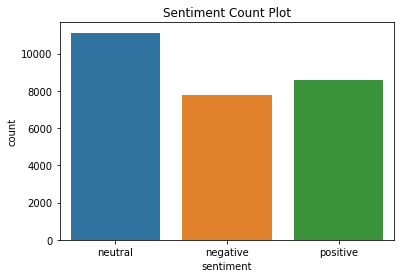

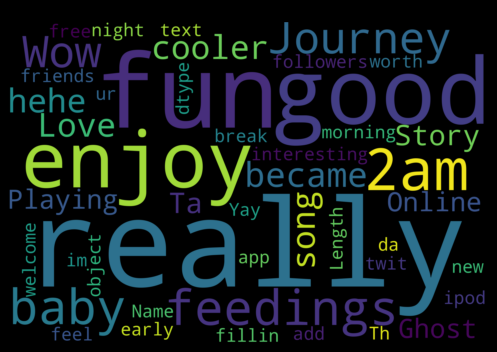

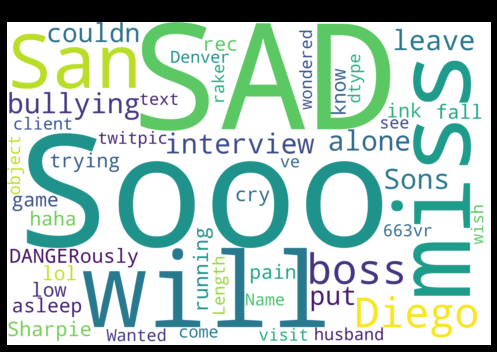

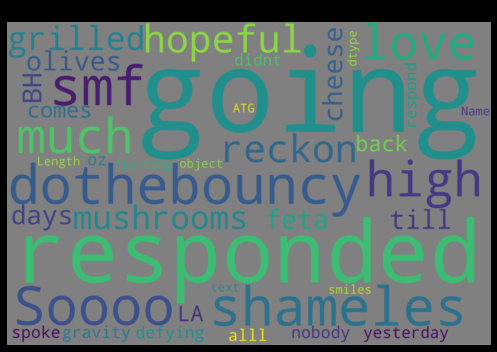

In [ ]:
# Exploratory Analysis

print(train_df.sentiment.value_counts())
sns.countplot(train_df.sentiment)
plt.title('Sentiment Count Plot')

def generate_word_cloud(text, color, title):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = color).generate(str(text))
    fig = plt.figure(
        figsize = (10, 5),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


generate_word_cloud(train_df.text[train_df.sentiment == 'positive'], 'black', 'positive cloud')
generate_word_cloud(train_df.text[train_df.sentiment == 'negative'], 'white', 'negative cloud')
generate_word_cloud(train_df.text[train_df.sentiment == 'neutral'], 'grey', 'neutral cloud')


## Data Clean up

In [ ]:
#convert to lowercase, strip and remove extra spaces
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    #text=re.compile('<.*?>').sub('', text) # remove any character enclosed in '<XXXXX>'
    #text = re.compile('[%s]' % re.escape(string.punctuation)).sub('', text)  # remove punctuations
    #text = re.sub('[^\w\s*]', '', text)  # remove punctuations
    text = re.sub(r'[^\w\s\*\']+', '', text) # remove punctuations except * and '
    text = re.sub(r"http\S+", "", text) # remove urls
    #text = re.sub(r'\[[0-9]*\]','',text)  # remove digits
    #text=re.sub(r'[^\w\s*]', '', str(text).lower().strip()) # remove non-word and whitespace
    #text = re.sub(r'\d','',text) # remove all digits
    #text = re.sub(r'\s+',' ',text) # remove all whitespaces
    return text

def finalpreprocess(string):
    return preprocess(string)

In [ ]:
train_df['clean_text'] = train_df['text'].apply(lambda x: finalpreprocess(x))
train_df['clean_sel_text'] = train_df['selected_text'].apply(lambda x: finalpreprocess(x))
train_df['clean_text_tokens']=[nltk.word_tokenize(i) for i in train_df['clean_text']]
train_df['clean_sel_text_tokens']=[nltk.word_tokenize(i) for i in train_df['clean_sel_text']]
train_df['cl_sel_length'] = train_df.clean_sel_text_tokens.str.len()
train_df['cl_length'] = train_df.clean_text_tokens.str.len()

In [ ]:
# drop columns with empty text after preprocessing
train_df = train_df.drop(train_df[train_df.cl_sel_length == 0].index)
train_df = train_df.drop(train_df[train_df.cl_length == 0].index)

In [ ]:
if PRE_TRAINED_MODEL_NAME=='bert':
  # tokenizer
  tokenizer = t.BertTokenizerFast.from_pretrained('bert-base-uncased')
  #tokenizer = t.BertTokenizerFast.from_pretrained('bert-large-uncased')
  #model
  bert_model = t.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
elif PRE_TRAINED_MODEL_NAME=='roberta':
  # tokenizer
  tokenizer = t.RobertaTokenizerFast.from_pretrained('roberta-base')
  #model
  bert_model = t.RobertaModel.from_pretrained('roberta-base', return_dict=False)
  #bert_model = t.RobertaForQuestionAnswering.from_pretrained('roberta-base')

else:
  print('Invalid model name '+ PRE_TRAINED_MODEL_NAME)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# find the token distributions for text column to set the max_length

token_lens = []
for text in train_df.text:
  tokens = tokenizer.encode(text, max_length=512, truncation=True)
  token_lens.append(len(tokens)) 

110


Text(0.5, 1.0, 'text distribution')

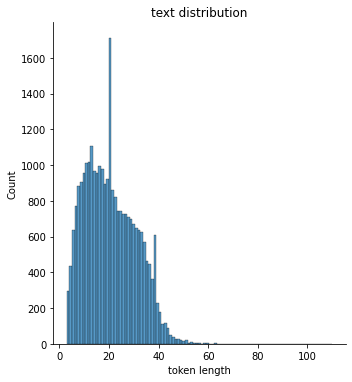

In [ ]:
print(max(token_lens)) 
MAX_LENGTH = max(token_lens)
sns.displot(token_lens)
plt.xlabel('token length')
plt.title('text distribution')

## Data Preparation

In [ ]:
# Prepare Dataset

class TweetDataset(Dataset):

  def __init__(self, tweet, sentiment, tokenizer, max_len, selected_text=None, test=False):
    self.tweet = tweet
    self.test = test
    if not self.test:
      self.selected_text = selected_text
    self.sentiment = sentiment
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweet)
  
  def __getitem__(self, item):
    tweet = " ".join(str(self.tweet[item]).split())
    
    if not self.test:
      selected_text = " ".join(str(self.selected_text[item]).split())
      selected_text_length = len(selected_text)
    
    tweet_length = len(tweet)
    start = -1
    end = -1  

    if not self.test:
      for idx in (i for i,e in enumerate(tweet) if e == selected_text[0]):
        if tweet[idx: idx + selected_text_length] == selected_text:
          start = idx
          end = idx + selected_text_length -1 # since length starts from 1 but array starts from 0
          break

      char_targets = [0] * tweet_length
      if start!=-1 and end!=-1:
        for j in range(start, end + 1): # since range is exclusive of end
          if tweet[j] != " ":
            char_targets[j] = 1

    tweet_tokenizer = self.tokenizer.encode_plus(tweet, return_offsets_mapping=True, return_token_type_ids=True)
    tweet_token_ids = tweet_tokenizer.input_ids
    tweet_tokens = self.tokenizer.convert_ids_to_tokens(tweet_token_ids)
    tweet_token_offsets = tweet_tokenizer.offset_mapping[1:-1]
    token_type_ids = tweet_tokenizer.token_type_ids
    mask = tweet_tokenizer.attention_mask


    #sentiment_tokenizer = self.tokenizer.encode_plus(self.sentiment[item], return_offsets_mapping=True, return_token_type_ids=True)
    #sentiment_token_ids = sentiment_tokenizer.input_ids
    #sent_token_type_ids = sentiment_tokenizer.token_type_ids
    #sentiment_mask = sentiment_tokenizer.attention_mask

    padding_len = self.max_len - len(tweet_token_ids)
    
    if not self.test:  
      targets = [0] * (len(tweet_token_ids) - 2)
      for j, (offset1,offset2) in enumerate(tweet_token_offsets):
        if sum(char_targets[offset1:offset2])>0:
          targets[j] = 1

      targets = [0] + targets + [0]
      targets_start = [0] * len(targets)
      targets_end = [0] * len(targets)

      non_zero = np.nonzero(targets)[0]
      if len(non_zero) >0:
        targets_start[non_zero[0]] = 1
        targets_end[non_zero[-1]] = 1

      targets = targets + [0] * padding_len
      targets_start = targets_start + [0] * padding_len
      targets_end = targets_end + [0] * padding_len  
    
    tweet_token_ids = tweet_token_ids + [0] * padding_len
    mask = mask + [0] * padding_len
    token_type_ids = token_type_ids + [0] * padding_len
    


    #sent_padding_len = self.max_len - len(sentiment_token_ids)
    #sentiment_token_ids = sentiment_token_ids + [0] * sent_padding_len
    #sentiment_mask = sentiment_mask + [0] * sent_padding_len
    #sent_token_type_ids = sent_token_type_ids + [0] * sent_padding_len


    sentiment = [0, 1, 0]
    if self.sentiment[item] == 'positive':
      sentiment = [1, 0, 0]
    if self.sentiment[item] == 'negative':
      sentiment = [0, 0, 1]

    return {
        'ids' : torch.tensor(tweet_token_ids, dtype=torch.long),
        'mask' : torch.tensor(mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        #'sentiment_ids' : torch.tensor(sentiment_token_ids, dtype=torch.long),
        #'sentiment_mask' : torch.tensor(sentiment_mask, dtype=torch.long),
        #'sentiment_token_type_ids' : torch.tensor(sent_token_type_ids, dtype=torch.long),
        'targets' : torch.tensor(targets, dtype=torch.long),
        'targets_start' : torch.tensor(targets_start, dtype=torch.long),
        'targets_end' : torch.tensor(targets_end, dtype=torch.long),
        'sentiment' : torch.tensor(sentiment, dtype=torch.long),
        'original_sentiment':self.sentiment[item],
        'padding_len' : torch.tensor(padding_len, dtype=torch.long),
        'tweet_tokens' : " ".join(tweet_tokens),
        'original_tweet' : self.tweet[item],
        'original_selected_text': self.selected_text[item]
        }  if not self.test else {'ids' : torch.tensor(tweet_token_ids, dtype=torch.long),
        'mask' : torch.tensor(mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'sentiment' : torch.tensor(sentiment, dtype=torch.long),
        'original_sentiment':self.sentiment[item],
        'padding_len' : torch.tensor(padding_len, dtype=torch.long),
        'tweet_tokens' : " ".join(tweet_tokens),
        'original_tweet' : self.tweet[item]
        }


In [ ]:
# Split data into train and validation sets
df_train, df_val = train_test_split(train_df, test_size=0.2, random_state=RANDOM_SEED, stratify=train_df.sentiment.values, shuffle=True)
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)

def data_loader(df, tokenizer, max_len, batch_size, test=False):
  ds = TweetDataset(tweet= df.text,
                    sentiment=df.sentiment,
                    selected_text=df.selected_text if not test else None,
                    tokenizer=tokenizer,
                    max_len=max_len, test=test)
  return DataLoader(ds, batch_size=batch_size, num_workers=NUM_WORKERS)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


## Evaluation Metric

In [ ]:
# Metric Jaccard score

def jaccard(target, predicted): 
    x = set(target.lower().split()) 
    y = set(predicted.lower().split())
    if (len(x)==0) & (len(y)==0): return 0.5
    z = x.intersection(y)
    return float(len(z)) / (len(x) + len(y) - len(z))

In [ ]:
# loss function
def loss_fn(o1, o2, t1, t2):
    l1 = nn.BCEWithLogitsLoss()(o1, t1)
    l2 = nn.BCEWithLogitsLoss()(o2, t2)
    return l1+l2

## Define Model

In [ ]:
# Build model

class BERTUncased(nn.Module):
    def __init__(self, model, sent_n_features=3, hidden_units=128, activation=F.leaky_relu):
        super(BERTUncased, self).__init__()
        self.sent_n_features = sent_n_features
        self.activation = activation
        self.hidden_units = hidden_units

        self.bert = model
        self.hidden = nn.Linear(768, hidden_units)
        self.out = nn.Linear(hidden_units, 2)

    def forward(self, ids, mask, token_type_ids, s_ids=None, s_mask=None, s_tok_type_ids=None, sentiments=None):
        sequence_op, pooled_op = self.bert(ids, mask, token_type_ids)
        #s_seq,s_pool = self.bert(s_ids, s_mask, s_tok_type_ids)
        hidden_op = self.activation(self.hidden(sequence_op))
        logits = self.out(hidden_op)
        start_logits, end_logits = logits.split(1, dim= -1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        return start_logits, end_logits

In [ ]:
def train(data_loader, model, optimizer, device, epoch, num_warmup_steps, num_train_steps, best_loss):
    model.train()
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)
    N_TOTAL_STEPS = len(data_loader)
    total_loss = 0
    tk = tqdm_notebook(enumerate(data_loader), total=len(data_loader), desc='Training: Epoch {}/{}'.format(epoch, EPOCHS))
    t0 = time.time()
    break_flag = False
    for i, d in tk:
        ids = d["ids"]
        mask = d["mask"]
        token_type_ids = d['token_type_ids']
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        sentiments = d['sentiment']
        #s_ids = d["sentiment_ids"]
        #s_mask = d["sentiment_mask"]
        #s_token_type_ids = d['sentiment_token_type_ids']

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.float)
        targets_end = targets_end.to(device, dtype=torch.float)
        sentiments= sentiments.to(device, dtype=torch.float)
        #s_ids = s_ids.to(device, dtype=torch.long)
        #s_token_type_ids = s_token_type_ids.to(device, dtype=torch.long)
        #s_mask = s_mask.to(device, dtype=torch.long)

        # clear previously calculated gradients 
        optimizer.zero_grad()

        # Preds
        o1, o2 = model(ids, mask, token_type_ids)

        # Loss
        loss = loss_fn(o1, o2, targets_start, targets_end)
       
        # add on to the total loss
        total_loss = total_loss + loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()
        scheduler.step()
        # check if 75% iterations are completed and loss compare with best loss
        if  N_TOTAL_STEPS*0.75 == i and total_loss/i > best_loss:
          break_flag = True
          break_step =i
          break
        tk.set_postfix(train_loss = loss.item())    
        
    training_time = format_time(time.time() - t0)
    #print(" Training epoch took: {:}".format(training_time))
    # Loss and accuracy for the complete epoch.
    epoch_loss = total_loss / (break_step if break_flag  else N_TOTAL_STEPS )
    #tk.set_postfix({'train_loss': epoch_loss, 'train_time': training_time})
    return epoch_loss  

In [ ]:
# Evaluation function.
def validate(data_loader, model, device, epoch):
    model.eval()
    valid_loss = 0.0
    N_TOTAL_STEPS = len(data_loader)
    predictions = []
    final_outputs_start = []
    final_outputs_end = []
    final_tweet_tokens = []
    final_padding_lens = []
    final_orig_selected = []
    final_orig_sentiment = []
    final_orig_tweet = []
    final_tweet_token_ids = []

    tk = tqdm_notebook(enumerate(data_loader), total=len(data_loader), desc='Evaluation: Epoch {}/{}'.format(epoch, EPOCHS))
    with torch.no_grad():
      for i, d in tk:     
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        tweet_tokens = d["tweet_tokens"]
        padding_len = d["padding_len"]
        sentiment = d["sentiment"]
        orig_selected = d["original_selected_text"]
        orig_sentiment = d["original_sentiment"]
        orig_tweet = d["original_tweet"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        sentiment = sentiment.to(device, dtype=torch.float)
        targets_start = targets_start.to(device, dtype=torch.float)
        targets_end = targets_end.to(device, dtype=torch.float)

        # Forward pass.
        outputs_start, outputs_end = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        # Calculate the loss.
        loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
        valid_loss += loss.item()      

        tk.set_postfix({'val_loss' : loss.item()})
        #print('start-->', outputs_start,'\n')
        #print('end -->', outputs_end,'\n')

        # append all data from dataloader batches to final variables for evaluation

        # convert output tensors to numpy arrays
        final_outputs_start.append(torch.sigmoid(outputs_start).cpu().detach().numpy())
        final_outputs_end.append(torch.sigmoid(outputs_end).cpu().detach().numpy())

        final_padding_lens.extend(padding_len.cpu().detach().numpy().tolist())
        final_tweet_token_ids.append(ids.cpu().detach().numpy().tolist())

        final_tweet_tokens.extend(tweet_tokens)
        final_orig_sentiment.extend(orig_sentiment)
        final_orig_selected.extend(orig_selected)
        final_orig_tweet.extend(orig_tweet)
    
    
    final_outputs_start = np.vstack(final_outputs_start)
    final_outputs_end = np.vstack(final_outputs_end)
    final_tweet_token_ids = np.vstack(final_tweet_token_ids)

    jaccards = []
    # set a threshold to pick the start and end index values
    threshold = 0.3   
    epoch_acc = 0

    for j in range(len(final_tweet_tokens)):
        target_string = final_orig_selected[j]
        tweet_tokens = final_tweet_tokens[j]
        padding_len = final_padding_lens[j]
        original_tweet = final_orig_tweet[j]
        sentiment_val = final_orig_sentiment[j]
        #print(target_string, '\ntokens: ', tweet_tokens,'\n pad: ', padding_len, '\norig_tweet:', original_tweet, '\nsentiment:', sentiment_val)
        #print('fin', final_outputs_start[j, :])

        # remove padding from tokens and set all values to '0' other than the threshold satisfying index to 1 
        if padding_len > 0:
            mask_start = final_outputs_start[j, :][:-padding_len] >= threshold
            mask_end = final_outputs_end[j, :][:-padding_len] >= threshold
            tweet_token_ids = final_tweet_token_ids[j, :][:-padding_len]
        else:
            mask_start = final_outputs_start[j, :] >= threshold
            mask_end = final_outputs_end[j, :] >= threshold
            tweet_token_ids = final_tweet_token_ids[j, :]
        
        #print(mask_start, mask_end)  
        
        pred_mask = [0] * len(mask_start)
        idx_start = np.nonzero(mask_start)[0]
        idx_end = np.nonzero(mask_end)[0]

        # set final modifications to start and end indices
        if len(idx_start) > 0:
            idx_start = idx_start[0]
            if len(idx_end) > 0:
                idx_end = idx_end[0]
            else:
                idx_end = idx_start
        else:
            idx_start = 0
            idx_end = 0

        for m in range(idx_start, idx_end + 1):
            pred_mask[m] = 1
        
        # get output predicted token ids where mask index is 1
        output_tokens = [x for k, x in enumerate(tweet_token_ids) if pred_mask[k] == 1]
        output_tokens = [x for x in output_tokens if x not in ("101", "102")] # remove cls and sep tokens
        #print('out_tokens:',output_tokens)

        # convert token ids to text tokens using decode method
        pred_string = tokenizer.decode(output_tokens)
        pred_string = pred_string.strip().lower()
        #print('fil-->',pred_string,'\ntarget_string--> ', target_string.strip().lower())

        if sentiment_val == "neutral":
            pred_string = original_tweet

        jaccard_score = jaccard(target_string.strip().lower(), pred_string) 
        jaccards.append(jaccard_score)
        #predictions.append(pred_string.strip())

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_loss / N_TOTAL_STEPS
    epoch_acc = np.mean(jaccards)
    #tk.set_postfix({'val_loss' : epoch_loss, 'val_acc': epoch_acc})
    return epoch_loss, epoch_acc

## Hyperparameter Tuning (Ray, Optuna)

In [ ]:
# Ray tune
def train_and_validate_ray(config):
  train_data_loader = data_loader(df_train, tokenizer, MAX_LENGTH, config['batch_size'])
  val_data_loader = data_loader(df_val, tokenizer, MAX_LENGTH, config['batch_size'])
  model = nn.DataParallel(BERTUncased(bert_model))
  model.to(device)
  #optimizer = AdamW(model.parameters(), lr=config['lr'])
  #optimizer = t_optim.Lamb(model.parameters(), lr=config['lr'])
  optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr= config['learning_rate'])
  best_jaccard = 0

  for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_loss = train(train_data_loader, model, optimizer, device, epoch+1) 
    valid_loss, valid_acc = validate(val_data_loader, model, device, epoch+1)

    print(f"Training loss: {train_loss:.3f}")
    print(f"Validation loss: {valid_loss:.3f}")
    with tune.checkpoint_dir(epoch) as checkpoint_dir:
      path = os.path.join(checkpoint_dir, 'checkpoint')
      torch.save((model.state_dict(), optimizer.state_dict()), path)
      tune.report(loss=valid_loss, accuracy=valid_acc) 

In [ ]:
# W/o Tuning
def train_and_validate_no_tuning(hidden_units=64, lr=5.13e-05, activation=F.logsigmoid, batch_size=32, optimizer='AdamW'):
  train_data_loader = data_loader(df_train, tokenizer, MAX_LENGTH, batch_size)
  val_data_loader = data_loader(df_val, tokenizer, MAX_LENGTH, batch_size)
  num_train_steps = int(len(df_train) / 32 * EPOCHS)
  model = nn.DataParallel(BERTUncased(bert_model, hidden_units=hidden_units, activation=activation))
  model.to(device)
  # Weight tuning for AdamW decay optimizer
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
  
  try:
    if optimizer == 'AdamW':
      optimizer = getattr(optim, optimizer)(optimizer_grouped_parameters, lr= lr)
    else:
      optimizer = getattr(optim, optimizer)(model.parameters(), lr= lr)
  except:
    optimizer = getattr(t_optim, optimizer)(model.parameters(), lr= lr)

  #optimizer = AdamW(model.parameters(), lr=lr)
  #optimizer = t_optim.Lamb(model.parameters(), lr=lr)
  best_jaccard = 0

  for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_loss = train(train_data_loader, model, optimizer, device, epoch+1, num_warmup_steps=0, num_train_steps=num_train_steps, best_loss=20.0) 
    valid_loss, valid_acc = validate(val_data_loader, model, device, epoch+1)
    if valid_acc > best_jaccard :
      torch.save(model, PATH+NAME_NO_TUNE)
      best_jaccard = valid_acc
    print(f"Training loss: {train_loss:.3f}")
    print(f"Validation loss: {valid_loss:.3f}")
    print(f"Validation acc: {valid_acc:.3f}")
  return best_jaccard, model  

In [ ]:
# Ray tune search
def run_search():
    # Define the parameter search configuration.
    config = {
        "hidden_units": tune.choice([100, 256, 512, 64, 128]),
        "lr": tune.loguniform(3e-4, 3e-5),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
  
    # Schduler to stop bad performing trails.
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=MAX_NUM_EPOCHS,
        grace_period=GRACE_PERIOD,
        reduction_factor=2)
    
    # Reporter to show on command line/output window
    reporter = CLIReporter(
        metric_columns=["loss", "accuracy", "training_iteration"])
    
    # Start run/search
    result = tune.run(
        tune.with_parameters(train_and_validate_ray),
        resources_per_trial={"cpu": CPU,"gpu": GPU},
        config=config,
        num_samples=NUM_SAMPLES,
        scheduler=scheduler,
        local_dir=PATH+'raytune_result',
        keep_checkpoints_num=1,
        checkpoint_score_attr='min-validation_loss',
        progress_reporter=reporter
    )
    # Extract the best trial run from the search.
    best_trial = result.get_best_trial(
        'loss', 'min', 'last'
    )
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation acc: {best_trial.last_result['accuracy']}")
    return result

In [ ]:
# https://huggingface.co/transformers/v3.3.1/training.html
def train_and_validate_optuna(config, trial, best_loss):
  train_data_loader = data_loader(df_train, tokenizer, MAX_LENGTH, config['batch_size'])
  val_data_loader = data_loader(df_val, tokenizer, MAX_LENGTH, config['batch_size'])
  model = nn.DataParallel(BERTUncased(bert_model, hidden_units=config['hidden_units'], activation=getattr(F, config['activation'])))
  model.to(device)
  num_train_steps = int(len(df_train) /config['batch_size'] * EPOCHS)
  #optimizer = AdamW(model.parameters(), lr=config['lr'])
  #optimizer = t_optim.Lamb(model.parameters(), lr=config['lr'])
  
  # Weight tuning for AdamW decay optimizer
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
  
  try:
    if config['optimizer'] == 'AdamW':
      optimizer = getattr(optim, config['optimizer'])(optimizer_grouped_parameters, lr= config['learning_rate'])
    else:
      optimizer = getattr(optim, config['optimizer'])(model.parameters(), lr= config['learning_rate'])
  except:
    optimizer = getattr(t_optim, config['optimizer'])(model.parameters(), lr= config['learning_rate'])

  valid_loss_per_epoch = []
  for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_loss = train(train_data_loader, model, optimizer, device, epoch+1, num_warmup_steps=0, num_train_steps=num_train_steps, best_loss=best_loss) 
    valid_loss, valid_acc = validate(val_data_loader, model, device, epoch+1)
    valid_loss_per_epoch.append(valid_loss)
    print(f"Training loss: {train_loss:.3f}")
    print(f"Validation loss: {valid_loss:.3f}")
    print(f"Validation accuracy: {valid_acc:.3f}")
  valid_loss = np.mean(valid_loss_per_epoch)  
  #trial.report(valid_acc, valid_loss)
  if trial.should_prune():
    raise optuna.TrialPruned()
  return valid_acc, model, valid_loss

In [ ]:
# Optuna Tuning
class Objective:

    def __init__(self):
        self.best_model = None
        self.model = None
        self.loss_per_trail = []
        self.best_loss = 10.0
        self.curr_loss = 0.0

    def __call__(self, trial):
        params = {
            'batch_size': trial.suggest_int("batch_size", 8, 64, step=8),
            'learning_rate': trial.suggest_loguniform('learning_rate', 3e-5, 1e-3),
            'optimizer': trial.suggest_categorical("optimizer", ["AdamW", 'Lamb', 'Adam']),
            'hidden_units': trial.suggest_int("hidden_units", 64, 128, step=32),
            'activation': trial.suggest_categorical("activation", ["logsigmoid", 'leaky_relu'])
        }

        accuracy, model, loss = train_and_validate_optuna(params, trial, self.best_loss)
        self.model = model
        self.loss_per_trail.append(loss)
        self.curr_loss = loss
        return accuracy

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self.model
            self.best_loss = self.curr_loss
            torch.save(self.best_model, PATH+NAME)

In [ ]:
# Optuna run search
objective = Objective()
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=2), study_name='tweet_sent_ext_optuna') # pruner for early stopping and discarding inefficient trails
study.optimize(objective, n_trials=10, show_progress_bar=True, callbacks=[objective.callback])
best_model = objective.best_model

[I 2022-04-13 14:33:38,145] A new study created in memory with name: tweet_sent_ext_optuna


  0%|          | 0/10 [00:00<?, ?it/s]

[INFO]: Epoch 1 of 1


Training: Epoch 1/1:   0%|          | 0/1374 [00:00<?, ?it/s]

Evaluation: Epoch 1/1:   0%|          | 0/344 [00:00<?, ?it/s]

Training loss: 0.271
Validation loss: 0.089
Validation accuracy: 0.395
[I 2022-04-13 14:51:17,195] Trial 0 finished with value: 0.39500358241742933 and parameters: {'batch_size': 16, 'learning_rate': 7.597437045170062e-05, 'optimizer': 'Lamb', 'hidden_units': 64, 'activation': 'leaky_relu'}. Best is trial 0 with value: 0.39500358241742933.
[INFO]: Epoch 1 of 1


Training: Epoch 1/1:   0%|          | 0/687 [00:00<?, ?it/s]

Evaluation: Epoch 1/1:   0%|          | 0/172 [00:00<?, ?it/s]

Training loss: 0.058
Validation loss: 0.034
Validation accuracy: 0.607
[I 2022-04-13 15:05:15,188] Trial 1 finished with value: 0.6068272226029926 and parameters: {'batch_size': 32, 'learning_rate': 3.1848693070799005e-05, 'optimizer': 'Adam', 'hidden_units': 128, 'activation': 'logsigmoid'}. Best is trial 1 with value: 0.6068272226029926.
[INFO]: Epoch 1 of 1


Training: Epoch 1/1:   0%|          | 0/344 [00:00<?, ?it/s]

Evaluation: Epoch 1/1:   0%|          | 0/86 [00:00<?, ?it/s]

Training loss: 0.101
Validation loss: 0.040
Validation accuracy: 0.624
[I 2022-04-13 15:15:22,207] Trial 2 finished with value: 0.623620916707824 and parameters: {'batch_size': 64, 'learning_rate': 5.1344264380312187e-05, 'optimizer': 'AdamW', 'hidden_units': 64, 'activation': 'logsigmoid'}. Best is trial 2 with value: 0.623620916707824.
[INFO]: Epoch 1 of 1


Training: Epoch 1/1:   0%|          | 0/687 [00:00<?, ?it/s]

Evaluation: Epoch 1/1:   0%|          | 0/172 [00:00<?, ?it/s]

Training loss: 0.098
Validation loss: 0.102
Validation accuracy: 0.394
[I 2022-04-13 15:29:19,679] Trial 3 finished with value: 0.3942757803795836 and parameters: {'batch_size': 32, 'learning_rate': 0.0004160904721523473, 'optimizer': 'Adam', 'hidden_units': 128, 'activation': 'leaky_relu'}. Best is trial 2 with value: 0.623620916707824.
[INFO]: Epoch 1 of 1


Training: Epoch 1/1:   0%|          | 0/687 [00:00<?, ?it/s]

Evaluation: Epoch 1/1:   0%|          | 0/172 [00:00<?, ?it/s]

Training loss: 0.108
Validation loss: 0.104
Validation accuracy: 0.394
[I 2022-04-13 15:43:14,974] Trial 4 finished with value: 0.3942757803795836 and parameters: {'batch_size': 32, 'learning_rate': 0.0008135103165698907, 'optimizer': 'Adam', 'hidden_units': 96, 'activation': 'logsigmoid'}. Best is trial 2 with value: 0.623620916707824.
[INFO]: Epoch 1 of 1


Training: Epoch 1/1:   0%|          | 0/687 [00:00<?, ?it/s]

Evaluation: Epoch 1/1:   0%|          | 0/172 [00:00<?, ?it/s]

Training loss: 0.113
Validation loss: 0.104
Validation accuracy: 0.394
[I 2022-04-13 15:57:18,309] Trial 5 finished with value: 0.3942757803795836 and parameters: {'batch_size': 32, 'learning_rate': 0.00016720791204306306, 'optimizer': 'AdamW', 'hidden_units': 96, 'activation': 'leaky_relu'}. Best is trial 2 with value: 0.623620916707824.
[INFO]: Epoch 1 of 1


Training: Epoch 1/1:   0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
# w/o tuning
acc, b_model = train_and_validate_no_tuning()

[INFO]: Epoch 1 of 1


Training: Epoch 1/1:   0%|          | 0/687 [00:00<?, ?it/s]

Evaluation: Epoch 1/1:   0%|          | 0/172 [00:00<?, ?it/s]

Training loss: 0.058
Validation loss: 0.033
Validation acc: 0.625


In [ ]:
# Ray tune run search
analysis = run_search()
#best_trained_model = BERTBaseUncased(bert_model, best_trial.config['hidden_units'])
#best_trained_model = nn.DataParallel(best_trained_model)
#best_trained_model.to(device)
#best_checkpoint_dir = best_trial.checkpoint.value
#model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint"))
#best_trained_model.load_state_dict(model_state)

In [ ]:
# clear GPU after running the epochs 
torch.cuda.empty_cache()
gc.collect()

88

## Visualizations After Optuna Tuning

In [ ]:
# optuna visualization
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)


In [ ]:
plot_parallel_coordinate(study, params=["batch_size", "optimizer", 'learning_rate', 'hidden_units', 'activation'])


In [ ]:
plot_slice(study)


In [ ]:
plot_param_importances(study)


In [ ]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

## Post Processing (Predictions)

In [ ]:
# Evaluation function.
def test_predictions(data_loader, model, device):
    model.eval()
    valid_loss = 0.0
    N_TOTAL_STEPS = len(data_loader)
    predictions = []
    final_outputs_start = []
    final_outputs_end = []
    final_tweet_tokens = []
    final_padding_lens = []
    final_orig_selected = []
    final_orig_sentiment = []
    final_orig_tweet = []
    final_tweet_token_ids = []

    tk = tqdm_notebook(enumerate(data_loader), total=len(data_loader), desc='Final Results:')
    with torch.no_grad():
      for i, d in tk:     
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        tweet_tokens = d["tweet_tokens"]
        padding_len = d["padding_len"]
        sentiment = d["sentiment"]
        orig_sentiment = d["original_sentiment"]
        orig_tweet = d["original_tweet"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        sentiment = sentiment.to(device, dtype=torch.float)

        # Forward pass.
        outputs_start, outputs_end = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )

        # append all data from dataloader batches to final variables for evaluation

        # convert output tensors to numpy arrays
        final_outputs_start.append(torch.sigmoid(outputs_start).cpu().detach().numpy())
        final_outputs_end.append(torch.sigmoid(outputs_end).cpu().detach().numpy())

        final_padding_lens.extend(padding_len.cpu().detach().numpy().tolist())
        final_tweet_token_ids.append(ids.cpu().detach().numpy().tolist())

        final_tweet_tokens.extend(tweet_tokens)
        final_orig_sentiment.extend(orig_sentiment)
        final_orig_tweet.extend(orig_tweet)
    
    
    final_outputs_start = np.vstack(final_outputs_start)
    final_outputs_end = np.vstack(final_outputs_end)
    final_tweet_token_ids = np.vstack(final_tweet_token_ids)

    jaccards = []
    # set a threshold to pick the start and end index values
    threshold = 0.3   
    epoch_acc = 0

    for j in range(len(final_tweet_tokens)):
        tweet_tokens = final_tweet_tokens[j]
        padding_len = final_padding_lens[j]
        original_tweet = final_orig_tweet[j]
        sentiment_val = final_orig_sentiment[j]

        # remove padding from tokens and set all values to '0' other than the threshold satisfying index to 1 
        if padding_len > 0:
            mask_start = final_outputs_start[j, :][:-padding_len] >= threshold
            mask_end = final_outputs_end[j, :][:-padding_len] >= threshold
            tweet_token_ids = final_tweet_token_ids[j, :][:-padding_len]
        else:
            mask_start = final_outputs_start[j, :] >= threshold
            mask_end = final_outputs_end[j, :] >= threshold
            tweet_token_ids = final_tweet_token_ids[j, :]
        
        
        pred_mask = [0] * len(mask_start)
        idx_start = np.nonzero(mask_start)[0]
        idx_end = np.nonzero(mask_end)[0]

        # set final modifications to start and end indices
        if len(idx_start) > 0:
            idx_start = idx_start[0]
            if len(idx_end) > 0:
                idx_end = idx_end[0]
            else:
                idx_end = idx_start
        else:
            idx_start = 0
            idx_end = 0

        for m in range(idx_start, idx_end + 1):
            pred_mask[m] = 1
        
        # get output predicted token ids where mask index is 1
        output_tokens = [x for k, x in enumerate(tweet_token_ids) if pred_mask[k] == 1]
        output_tokens = [x for x in output_tokens if x not in ("101", "102")] # remove cls and sep tokens
        #print('out_tokens:',output_tokens)

        # convert token ids to text tokens using decode method
        pred_string = tokenizer.decode(output_tokens)
        pred_string = pred_string.strip().lower()
        #print('fil-->',pred_string,'\ntarget_string--> ', target_string.strip().lower())

        if sentiment_val == "neutral":
            pred_string = original_tweet

        predictions.append(pred_string.strip())

    return predictions

In [ ]:
# Load Data
test_df = pd.read_csv('/content/drive/MyDrive/Project_ML/test.csv').dropna()
test_df.head(5)

test_data_loader = data_loader(test_df, tokenizer, MAX_LENGTH, 32, test=True)

test_data_loader


In [ ]:
#Test Block for evaluation of validation dataset  with saved model
# https://python.tutorialink.com/is-there-a-way-to-use-torch-nn-dataparallel-with-cpu/
device_test = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(PATH+NAME_NO_TUNE, map_location=torch.device('cpu')) # load GPU saved model to CPU
preds = test_predictions(test_data_loader, model.module.to(device_test), device_test) # bypass nn.DataParallel call if GPU is not used
preds

In [ ]:
test_df['pred_sel_text'] =  preds

In [ ]:
test_df.tail(25)

,textID,text,sentiment,pred_sel_text
3509,72b5155719,The Killers are coming to TD Banknorth in Bost...,negative,the killers are coming to td banknorth in bost...
3510,bbfe533366,"In my moms hair salon, dying my hair",neutral,"In my moms hair salon, dying my hair"
3511,4cb0ab19ed,"Good morning, to all the mommies happy mothers...",positive,"good morning, to all the mommies happy mothers..."
3512,58e2a00ab8,that`s not good,negative,that ` s not good
3513,0a0e2a4f78,"Thanks! I love it they have a video, so you d...",positive,thanks!
3514,975554343f,I just noticed that They are so ridiculous,negative,ridiculous
3515,c7be378db2,im riding the highs and lows of moods now......,neutral,im riding the highs and lows of moods now.... ...
3516,87737f8e62,i hate it when a website says the ticket price...,negative,i hate
3517,558fe1316b,On a 10min brake. At wrrkk ... its 11:06 and i...,neutral,On a 10min brake. At wrrkk ... its 11:06 and i...
3518,a6687519e2,"ok outta all 981 of my followers, only about 1...",neutral,"ok outta all 981 of my followers, only about 1..."


## Below code blocks are used for testing while development

In [ ]:
#Test Block for evaluation of validation dataset  with saved model
model = torch.load(PATH+NAME)
df_val = df_val.sample(n=3).reset_index(drop=True)
print(df_val.selected_text, df_val.sentiment)
val_data_loader = data_loader(df_val, tokenizer, MAX_LENGTH, 8)
valid_loss, valid_acc = validate(val_data_loader, model, device, 1)
valid_acc

In [ ]:
tweet =" Hello,       How r u??     "
selected_text = 'Hello'
tweet = " ".join(str(tweet).split())
print(tweet)
#print(selected_text[0])


#tweet_tokenizer = tokenizer_bert.encode_plus(tweet, return_offsets_mapping=True, max_length=MAX_LENGTH, padding = 'max_length')


tweet_tokenizer = tokenizer.encode_plus(tweet, return_offsets_mapping=True, return_token_type_ids=True)
tweet_token_ids = tweet_tokenizer.input_ids
tweet_tokens = tokenizer.convert_ids_to_tokens(tweet_token_ids)
print(tweet_tokenizer.keys())
#tweet_token_offsets = tweet_tokenizer.offset_mapping[1:-1]
token_type_ids = tweet_tokenizer.token_type_ids
mask = tweet_tokenizer.attention_mask

print(len(tweet_tokenizer.input_ids))
print(tweet_tokenizer.input_ids)
print(len(tweet_tokenizer.attention_mask))
print(tweet_tokens)
print(tweet_tokenizer.keys())



tweet_tokens = tokenizer.decode(tweet_tokenizer.input_ids)
#print(tweet_tokenizer.keys())

Hello, How r u??
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping'])
9
[101, 7592, 1010, 2129, 1054, 1057, 1029, 1029, 102]
9
['[CLS]', 'hello', ',', 'how', 'r', 'u', '?', '?', '[SEP]']
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping'])


In [ ]:
NUM_LABELS = len(train_df.sentiment.unique())
NUM_LABELS

In [ ]:
getattr(F, 'relu')

<function torch.nn.functional.relu>

In [ ]:
x= False
if not x:
  print('hello')
else:
  print(x)  

hello
